# DS 4400 Final Project
## Group 8 Lang Shao, Haoyuan Deng, Kexin Huang

## Data Cleaning

In [45]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import json
from IPython.display import HTML, display
import os
import altair as alt

In [46]:
df = pd.read_csv('fy2024-property-assessment-data_1_5_2024.csv')

# fix data types for numeric columns stored as objects
numeric_cols_to_convert = ['TOTAL_VALUE', 'LAND_SF', 'LAND_VALUE', 'BLDG_VALUE']
for col in numeric_cols_to_convert:
    # remove commas, dollar signs, and other non-numeric characters, then convert to float
    df[col] = pd.to_numeric(df[col].replace('[\$,]', '', regex=True), errors='coerce')

# ensure other numeric columns are properly typed
numeric_cols = ['TOTAL_VALUE', 'LAND_SF', 'LIVING_AREA', 'YR_BUILT', 'BED_RMS', 
                'FULL_BTH', 'HLF_BTH', 'FIREPLACES', 'LAND_VALUE', 'BLDG_VALUE']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# convert ZIP_CODE to string and remove decimals
df['ZIP_CODE'] = df['ZIP_CODE'].fillna(0).astype(int).astype(str).str.zfill(5)

# handle missing values
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        if col in ['TOTAL_VALUE', 'LIVING_AREA']: 
            df = df.dropna(subset=[col])
        else: 
            df[col] = df[col].fillna(df[col].median())
            print(f"Filled missing values in {col} with median: {df[col].median()}")

# fill with 'Unknown' for empty rows
categorical_cols = ['OVERALL_COND', 'KITCHEN_STYLE1', 'BTHRM_STYLE1', 'AC_TYPE', 
                    'HEAT_TYPE', 'OWN_OCC', 'PROP_VIEW', 'CORNER_UNIT']
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna('Unknown')
        print(f"Filled missing values in {col} with 'Unknown'")

# remove outliers
df = df[df['TOTAL_VALUE'] >= 0] 
df = df[df['LAND_SF'] >= 0]
df = df[df['LIVING_AREA'] >= 0]
df = df[df['YR_BUILT'].between(1600, 2025, inclusive='both') | df['YR_BUILT'].isna()]

# Cap extreme values for TOTAL_VALUE
df['TOTAL_VALUE'] = winsorize(df['TOTAL_VALUE'].dropna(), limits=[0.05, 0.05])

# standardize categorical data
df['OWN_OCC'] = df['OWN_OCC'].str.upper().replace({'YES': 'Y', 'NO': 'N', '': 'Unknown'})
for col in ['OVERALL_COND', 'KITCHEN_STYLE1', 'BTHRM_STYLE1', 'AC_TYPE', 'HEAT_TYPE']:
    df[col] = df[col].str.lower().str.strip()

# create subsets
keep_cols = ['ZIP_CODE', 'TOTAL_VALUE', 'LAND_SF', 'LIVING_AREA', 'YR_BUILT', 'BED_RMS', 
             'FULL_BTH', 'HLF_BTH', 'OVERALL_COND', 'KITCHEN_STYLE1', 'BTHRM_STYLE1', 
             'AC_TYPE', 'HEAT_TYPE', 'FIREPLACES', 'OWN_OCC', 'LAND_VALUE', 'BLDG_VALUE', 
             'PROP_VIEW', 'CORNER_UNIT']
df_cleaned = df[keep_cols]

<>:7: SyntaxWarning:

invalid escape sequence '\$'

<>:7: SyntaxWarning:

invalid escape sequence '\$'

/var/folders/sw/4xrc7st92kl0js_sn1vflh100000gn/T/ipykernel_90656/3730083930.py:7: SyntaxWarning:

invalid escape sequence '\$'

/var/folders/sw/4xrc7st92kl0js_sn1vflh100000gn/T/ipykernel_90656/3730083930.py:1: DtypeWarning:

Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.



Filled missing values in LAND_SF with median: 1996.0
Filled missing values in YR_BUILT with median: 1920.0
Filled missing values in BED_RMS with median: 3.0
Filled missing values in FULL_BTH with median: 1.0
Filled missing values in HLF_BTH with median: 0.0
Filled missing values in FIREPLACES with median: 0.0
Filled missing values in OVERALL_COND with 'Unknown'
Filled missing values in KITCHEN_STYLE1 with 'Unknown'
Filled missing values in BTHRM_STYLE1 with 'Unknown'
Filled missing values in AC_TYPE with 'Unknown'
Filled missing values in HEAT_TYPE with 'Unknown'
Filled missing values in PROP_VIEW with 'Unknown'
Filled missing values in CORNER_UNIT with 'Unknown'


In [47]:
def extract_unique_zip_codes(csv_file_path, zip_column_name="ZIP_CODE"):
    """
    Extract unique zip codes from a large CSV file
    """
    chunk_size = 100000
    
    unique_zips = set()
    
    # process the file in chunks
    for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size, usecols=[zip_column_name], 
                            dtype={zip_column_name: str}, low_memory=False):
        # filter out missing values before adding to the set
        valid_zips = chunk[~chunk[zip_column_name].isna()][zip_column_name].astype(str).unique()
        unique_zips.update(valid_zips)
    
    # remove any nan strings
    if 'nan' in unique_zips:
        unique_zips.remove('nan')
    
    # convert to integers and sort
    unique_zips_list = sorted([int(z) for z in unique_zips if z.isdigit()])
    return unique_zips_list

# call
if __name__ == "__main__":
    file_name = "fy2024-property-assessment-data_1_5_2024.csv"
    zip_column = "ZIP_CODE"
    
    unique_zips = extract_unique_zip_codes(file_name, zip_column)

## Visualizations - 1. Map

In [48]:
# calculate median values for each zip code
zip_stats = df.groupby('ZIP_CODE').agg({
    'TOTAL_VALUE': 'median',
    'LIVING_AREA': 'median',
    'LAND_SF': 'median',
    'HLF_BTH': 'median',
    'YR_BUILT': 'median'
}).reset_index()

# calculate price/square foot
zip_stats['PRICE_PER_SQFT'] = zip_stats['TOTAL_VALUE'] / zip_stats['LIVING_AREA']

# add count of properties per zip code
zip_stats['PROPERTY_COUNT'] = df.groupby('ZIP_CODE').size().values

# print the aggregated data
print(zip_stats.head())
print(f"\nZip codes with highest median values:")
print(zip_stats.sort_values('TOTAL_VALUE', ascending=False).head(5)[['ZIP_CODE', 'TOTAL_VALUE', 'PRICE_PER_SQFT', 'PROPERTY_COUNT']])

  ZIP_CODE  TOTAL_VALUE  LIVING_AREA  LAND_SF  HLF_BTH  YR_BUILT  \
0    00000    2759900.0      27312.0  35030.0      0.0    2007.0   
1    02026     621300.0       1384.8   6075.0      1.0    1940.0   
2    02108    1390200.0       1291.0   1137.0      0.0    1899.0   
3    02109     804000.0       1085.0   1021.0      0.0    1900.0   
4    02110    1145850.0       1232.5   1232.0      0.0    1972.0   

   PRICE_PER_SQFT  PROPERTY_COUNT  
0      101.050820               1  
1      448.656846               4  
2     1076.839659            1815  
3      741.013825            1647  
4      929.695740            1914  

Zip codes with highest median values:
   ZIP_CODE  TOTAL_VALUE  PRICE_PER_SQFT  PROPERTY_COUNT
0     00000    2759900.0      101.050820               1
24    02133    2759900.0        5.311300               1
30    02201    2759900.0       31.995687               2
29    02199    2759900.0      718.630387              34
33    02219    2563500.0       47.028068           

In [49]:
def get_zip_geo_coordinates(zip_codes):
    """
    Get approximate latitude/longitude for ZIP codes in this dataset using public data.

    """
    boston_zip = {
    '02026': (42.2465, -71.1265),  # Dedham
    '02108': (42.3586, -71.0631),  # Downtown/Beacon Hill
    '02109': (42.3604, -71.0545),  # North End
    '02110': (42.3591, -71.0507),  # Financial District
    '02111': (42.3519, -71.0629),  # Chinatown
    '02113': (42.3661, -71.0543),  # North End
    '02114': (42.3625, -71.0677),  # West End/Beacon Hill
    '02115': (42.3431, -71.0887),  # Fenway/Longwood
    '02116': (42.3523, -71.0737),  # Back Bay
    '02118': (42.3417, -71.0727),  # South End
    '02119': (42.3267, -71.0918),  # Roxbury
    '02120': (42.3353, -71.0956),  # Mission Hill
    '02121': (42.3064, -71.0793),  # Dorchester
    '02122': (42.3011, -71.0552),  # Dorchester
    '02124': (42.2845, -71.0762),  # Dorchester
    '02125': (42.3118, -71.0606),  # Dorchester
    '02126': (42.2690, -71.0928),  # Mattapan
    '02127': (42.3382, -71.0476),  # South Boston
    '02128': (42.3758, -71.0258),  # East Boston
    '02129': (42.3785, -71.0664),  # Charlestown
    '02130': (42.3088, -71.1132),  # Jamaica Plain
    '02131': (42.2841, -71.1328),  # Roslindale
    '02132': (42.2804, -71.1663),  # West Roxbury
    '02133': (42.3604, -71.0594),  # Government Center
    '02134': (42.3562, -71.1311),  # Allston
    '02135': (42.3503, -71.1540),  # Brighton
    '02136': (42.2555, -71.1238),  # Hyde Park
    '02137': (42.3075, -71.1013),  # Readville
    '02199': (42.3469, -71.0822),  # Prudential
    '02201': (42.3564, -71.0577),  # Downtown Crossing
    '02210': (42.3482, -71.0456),  # Seaport
    '02215': (42.3477, -71.1042),  # Kenmore/BU
    '02219': (42.3523, -71.0567),  # Fort Point
    '02445': (42.3310, -71.1226),  # Brookline
    '02446': (42.3418, -71.1212),  # Brookline
    '02458': (42.3651, -71.1932),  # Newton
    '02467': (42.3229, -71.1669),  # Chestnut Hill
}
    
    all_zips_coords = {}
    known_lats = [coords[0] for coords in boston_zip.values()]
    known_lons = [coords[1] for coords in boston_zip.values()]
    
    center_lat = sum(known_lats) / len(known_lats)
    center_lon = sum(known_lons) / len(known_lons)
    
    for zip_code in zip_codes:
        if zip_code in boston_zip:
            all_zips_coords[zip_code] = boston_zip[zip_code]
        else:
            import random
            # use zipcode as seed for consistency
            random.seed(int(zip_code)) 
            lat_offset = random.uniform(-0.05, 0.05)
            lon_offset = random.uniform(-0.05, 0.05)
            all_zips_coords[zip_code] = (center_lat + lat_offset, center_lon + lon_offset)
    
    return all_zips_coords

# get coordinates from the dataset
zip_coordinates = get_zip_geo_coordinates(zip_stats['ZIP_CODE'].unique())

# add coordinates to aggregated data
zip_stats['LAT'] = zip_stats['ZIP_CODE'].map(lambda z: zip_coordinates.get(z, (0, 0))[0])
zip_stats['LON'] = zip_stats['ZIP_CODE'].map(lambda z: zip_coordinates.get(z, (0, 0))[1])

In [50]:
# normalize the values for bubble size
zip_stats['BUBBLE_SIZE'] = (zip_stats['PROPERTY_COUNT'] / zip_stats['PROPERTY_COUNT'].max() * 30) + 10

# format values for hover text
zip_stats['HOVER_VALUE'] = zip_stats['TOTAL_VALUE'].apply(lambda x: f"${x:,.0f}")
zip_stats['HOVER_SQFT'] = zip_stats['PRICE_PER_SQFT'].apply(lambda x: f"${x:,.0f}")

# create the color scale
fig = px.scatter_mapbox(
    zip_stats, 
    lat="LAT", 
    lon="LON", 
    color="TOTAL_VALUE",
    size="BUBBLE_SIZE",
    hover_name="ZIP_CODE",
    hover_data={
        "TOTAL_VALUE": False,  
        "BUBBLE_SIZE": False,
        "LAT": False,
        "LON": False, 
        "HOVER_VALUE": True,   
        "HOVER_SQFT": True,   
        "PROPERTY_COUNT": True, 
    },
    color_continuous_scale="Viridis",
    size_max=40,
    zoom=10.5,
    height=800,
    width=1000,
    mapbox_style="carto-positron",
    center={"lat": 42.3601, "lon": -71.0589},  
    labels={
        "HOVER_VALUE": "Median Value",
        "HOVER_SQFT": "Price per SqFt",
        "PROPERTY_COUNT": "Properties",
    },
    title="Boston Housing Prices by ZIP Code"
)

# update hover template
fig.update_traces(
    hovertemplate="<b>ZIP Code: %{hovertext}</b><br>" +
                  "Median Value: %{customdata[0]}<br>" +
                  "Price per SqFt: %{customdata[1]}<br>" +
                  "Properties: %{customdata[2]}<br>"
)

# add annotation explaining the visualization
fig.add_annotation(
    x=0.01, y=0.01,
    xref="paper", yref="paper",
    text="Circle size represents number of properties in each ZIP code.<br>Color represents median home value.",
    showarrow=False,
    font=dict(size=12),
    bgcolor="white",
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    align="left"
)

# configure the colorbar
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Median<br>Home Value",
        tickprefix="$",
        tickformat=",.0f",
    )
)

# show and save the map
fig.show()
fig.write_html("boston_housing_prices_map.html")

## Visualization - 2.Property Age vs. Value Analysis by Neighborhood Stacked Bar Chart

In [51]:
df_cleaned = df_cleaned.copy()

# compute VALUE_PER_SF if it been cleaned
if 'VALUE_PER_SF' not in df_cleaned.columns:
    df_cleaned['VALUE_PER_SF'] = df_cleaned['TOTAL_VALUE'] / df_cleaned['LIVING_AREA']

# bin YR_BUILT into decades for cleaner x-axis
df_cleaned['YR_BUILT_BIN'] = pd.cut(df_cleaned['YR_BUILT'], bins=range(1850, 2030, 10), labels=[f"{y}-{y+9}" for y in range(1850, 2020, 10)])

# filter to top 5 ZIP codes by average VALUE_PER_SF
top_5_zip = df_cleaned.groupby('ZIP_CODE')['VALUE_PER_SF'].mean().nlargest(5).index.tolist()
df_top_5 = df_cleaned[df_cleaned['ZIP_CODE'].isin(top_5_zip)].dropna(subset=['YR_BUILT_BIN', 'VALUE_PER_SF'])

# compute avg VALUE_PER_SF per ZIP code and year bin
df_agg = df_top_5.groupby(['YR_BUILT_BIN', 'ZIP_CODE'])['VALUE_PER_SF'].mean().reset_index()

# define ZIP code to neighborhood mapping
zip_to_neighborhood = {
    '02115': 'Back Bay/Fenway',   
    '02114': 'Beacon Hill',       
    '02109': 'North End',   
    '02108': 'Downtown',  
    '02210': 'Seaport',   
    '02110': 'Financial District',
    '02116': 'Back Bay',      
    '02118': 'South End',    
    '02215': 'Fenway/Kenmore',  
    '02134': 'Allston'      
}

# add neighborhood names to the df
df_agg['ZIP_CODE_WITH_NAME'] = df_agg['ZIP_CODE'].map(lambda x: f"{x} - {zip_to_neighborhood[x]}")

# define selection for ZIP code filtering
selection = alt.selection_point(fields=['ZIP_CODE_WITH_NAME'], bind='legend')

/var/folders/sw/4xrc7st92kl0js_sn1vflh100000gn/T/ipykernel_90656/2969179227.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [52]:
# create stacked bar chart
chart = alt.Chart(df_agg).mark_bar().encode(
    x=alt.X('YR_BUILT_BIN:N', title='Year Built Range', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('VALUE_PER_SF:Q', title='Average Value per Square Foot ($)', stack='zero'),
    color=alt.Color('ZIP_CODE_WITH_NAME:N', title='ZIP Code - Neighborhood', scale=alt.Scale(scheme='category20')),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip=[
        alt.Tooltip('YR_BUILT_BIN:N', title='Year Built Range'),
        alt.Tooltip('ZIP_CODE_WITH_NAME:N', title='ZIP Code - Neighborhood'),
        alt.Tooltip('VALUE_PER_SF:Q', title='Avg Value per Sq Ft ($)', format='.2f')
    ]
).properties(
    width=600,
    height=400,
    title='Property Age vs Average Value per Square Foot by ZIP Code (Stacked)'
).add_params(
    selection
).interactive()

# save the chart
chart.save('stacked_property_age_vs_value_per_sf.html')
chart

alt.Chart(...)

## Visualization - 3.Housing Characteristics Dashboard

In [53]:
# convert dataframe to list of dictionaries for D3
housing_data = df_cleaned.to_dict(orient='records')

# save the data as JSON 
with open('housing_data.json', 'w') as f:
    json.dump(housing_data, f)

# read the dashboard HTML 
with open('housing_impact_dashboard_with_data.html', 'r') as f:
    dashboard_html = f.read()

In [54]:
# find the loadData function
dashboard_html = dashboard_html.replace(
    "const sampleData = [];",
    f"const sampleData = {json.dumps(housing_data[:10000])}; // Using first 10000 records for better representation"
)

# save the HTML
with open('housing_impact_dashboard_with_data.html', 'w') as f:
    f.write(dashboard_html)

In [55]:
# display the dashboard
display(HTML(f"""
<div style="width:100%; height:600px;">
    <iframe src="housing_impact_dashboard_with_data.html" width="100%" height="100%" frameborder="0"></iframe>
</div>
"""))

# create a link to
from IPython.display import FileLink

FileLink('housing_impact_dashboard_with_data.html')

/Users/hydec5even/Desktop/DS4200/4200 Proejct/My Vis/housing_impact_dashboard_with_data.html

## Visualization 4. Amenities and Condition Price Premium Analysis Heatmap

In [56]:
import altair as alt
import pandas as pd

# Define ZIP code to neighborhood mapping
zip_to_neighborhood = {
    '02115': 'Back Bay/Fenway',
    '02114': 'Beacon Hill',
    '02109': 'North End',
    '02108': 'Downtown',
    '02210': 'Seaport',
    '02110': 'Financial District',
    '02116': 'Back Bay',
    '02118': 'South End',
    '02215': 'Fenway/Kenmore',
    '02134': 'Allston'
}

# Filter to only the specified ZIP codes
df_filtered = df_cleaned[df_cleaned['ZIP_CODE'].isin(zip_to_neighborhood.keys())].dropna(subset=['OVERALL_COND', 'KITCHEN_STYLE1', 'BTHRM_STYLE1', 'TOTAL_VALUE'])

# Map ZIP codes to neighborhoods
df_filtered['NEIGHBORHOOD'] = df_filtered['ZIP_CODE'].map(zip_to_neighborhood)

# Explicitly ensure OVERALL_COND, KITCHEN_STYLE1, and BTHRM_STYLE1 retain full names
# No stripping or modification for these columns
print("Unique OVERALL_COND values:", df_filtered['OVERALL_COND'].unique())
print("Unique KITCHEN_STYLE1 values:", df_filtered['KITCHEN_STYLE1'].unique())
print("Unique BTHRM_STYLE1 values:", df_filtered['BTHRM_STYLE1'].unique())

# Clean only unused columns (AC_TYPE, HEAT_TYPE) if needed
for col in ['AC_TYPE', 'HEAT_TYPE']:
    df_filtered[col] = df_filtered[col].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) and ' - ' in x else x)

# Convert FIREPLACES to numeric then categorical (e.g., '0', '1', '2+')
df_filtered['FIREPLACES'] = pd.to_numeric(df_filtered['FIREPLACES'], errors='coerce')
df_filtered['FIREPLACES'] = df_filtered['FIREPLACES'].apply(lambda x: '2+' if pd.notna(x) and x >= 2 else str(int(x)) if pd.notna(x) else 'Unknown')
# Filter out rows where KITCHEN_STYLE1 or BTHRM_STYLE1 is "unknown"
df_filtered = df_filtered[(df_filtered['KITCHEN_STYLE1'] != 'unknown') & (df_filtered['BTHRM_STYLE1'] != 'unknown')]

# Prepare data for both KITCHEN_STYLE1 and BTHRM_STYLE1 with full names
df_agg_kitchen = df_filtered.groupby(['NEIGHBORHOOD', 'OVERALL_COND', 'KITCHEN_STYLE1'])['TOTAL_VALUE'].mean().reset_index()
df_agg_bathroom = df_filtered.groupby(['NEIGHBORHOOD', 'OVERALL_COND', 'BTHRM_STYLE1'])['TOTAL_VALUE'].mean().reset_index()

# Rename columns to a common name for Y-axis switching
df_agg_kitchen = df_agg_kitchen.rename(columns={'KITCHEN_STYLE1': 'Y_VAR'})
df_agg_bathroom = df_agg_bathroom.rename(columns={'BTHRM_STYLE1': 'Y_VAR'})
df_agg_kitchen['Y_VAR_TYPE'] = 'Kitchen Style'
df_agg_bathroom['Y_VAR_TYPE'] = 'Bathroom Style'

# Combine the datasets
df_agg = pd.concat([df_agg_kitchen, df_agg_bathroom], ignore_index=True)

# Verify full names in aggregated data
print("Unique Y_VAR values in df_agg:", df_agg['Y_VAR'].unique())

# Define dropdown for OVERALL_COND filter with full names
condition_options = df_agg['OVERALL_COND'].unique().tolist()
condition_labels = [cond for cond in condition_options]  
condition_filter = alt.binding_select(
    options=condition_options,
    labels=condition_labels,
    name='Overall Condition: '
)
condition_selection = alt.selection_point(fields=['OVERALL_COND'], bind=condition_filter)

# Define dropdown for Y-axis variable (KITCHEN_STYLE1 or BTHRM_STYLE1)
y_var_options = ['Kitchen Style', 'Bathroom Style']
y_var_filter = alt.binding_select(
    options=y_var_options,
    name='Style Category: '
)
y_var_selection = alt.selection_point(fields=['Y_VAR_TYPE'], bind=y_var_filter)

Unique OVERALL_COND values: ['g - good' 'a - average' 'unknown' 'f - fair' 'vg - very good'
 'e - excellent' 'ex - excellent' 'vp - very poor' 'p - poor'
 'us - unsound']
Unique KITCHEN_STYLE1 values: ['s - semi-modern' 'm - modern' 'unknown' 'n - no remodeling' 'l - luxury']
Unique BTHRM_STYLE1 values: ['s - semi-modern' 'm - modern' 'unknown' 'l - luxury' 'n - no remodeling']
Unique Y_VAR values in df_agg: ['l - luxury' 'm - modern' 'n - no remodeling' 's - semi-modern']


In [57]:
# Create heatmap
heatmap = alt.Chart(df_agg).mark_rect().encode(
    x=alt.X('NEIGHBORHOOD:N', title='Neighborhood', sort='-color', axis=alt.Axis(labelAngle=45)),  
    y=alt.Y('Y_VAR:N', title='Amenity Style'), 
    color=alt.Color('TOTAL_VALUE:Q', title='Avg Total Value ($)', scale=alt.Scale(scheme='viridis'), legend=alt.Legend(format=',.0f')),
    tooltip=[
        alt.Tooltip('NEIGHBORHOOD:N', title='Neighborhood'),
        alt.Tooltip('OVERALL_COND:N', title='Overall Condition'),  
        alt.Tooltip('Y_VAR:N', title='Amenity Style'),  
        alt.Tooltip('Y_VAR_TYPE:N', title='Amenity Type'),
        alt.Tooltip('TOTAL_VALUE:Q', title='Avg Total Value ($)', format=',.0f')
    ]
).properties(
    width=400,
    height=300,
    title='Amenities and Condition Price Premium by Neighborhood'
).add_params(
    condition_selection,
    y_var_selection
).transform_filter(
    condition_selection & y_var_selection  
).interactive()

# Save the chart
heatmap.save('amenities_condition_price_premium_full_names.html')
heatmap

alt.Chart(...)

## Visualization - 5. Owner-Occupancy and Property Value Relationship (Boxplot & Barplot)

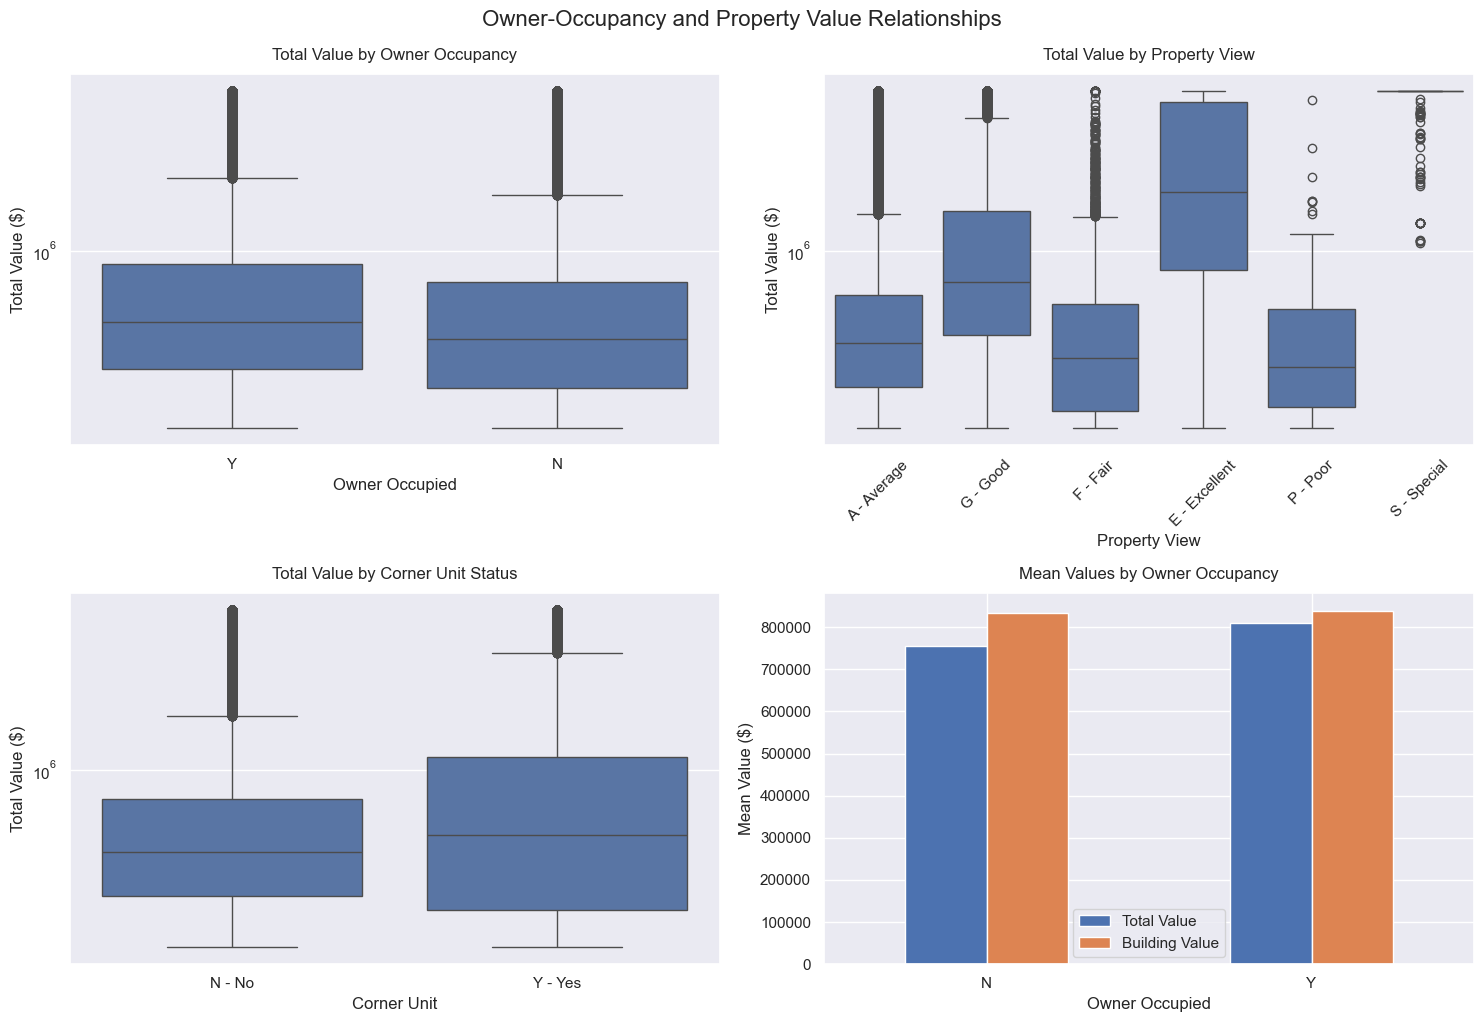

In [58]:
df_filtered = df_cleaned[
    (df_cleaned['OWN_OCC'] != 'Unknown') & 
    (df_cleaned['PROP_VIEW'] != 'Unknown') & 
    (df_cleaned['CORNER_UNIT'] != 'Unknown')
]

# set Seaborn's default styling to call
sns.set()
sns.set_palette("deep")

# create figure
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# create plot1 Box plot: Owner Occupancy vs Total Value
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df_filtered, x='OWN_OCC', y='TOTAL_VALUE', ax=ax1)
ax1.set_title('Total Value by Owner Occupancy', pad=10)
ax1.set_xlabel('Owner Occupied')
ax1.set_ylabel('Total Value ($)')
ax1.set_yscale('log')

# create plot 2 Box plot: Property View vs Total Value
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=df_filtered, x='PROP_VIEW', y='TOTAL_VALUE', ax=ax2)
ax2.set_title('Total Value by Property View', pad=10)
ax2.set_xlabel('Property View')
ax2.set_ylabel('Total Value ($)')
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)

# create plot 3 Box plot: Corner Unit vs Total Value
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df_filtered, x='CORNER_UNIT', y='TOTAL_VALUE', ax=ax3)
ax3.set_title('Total Value by Corner Unit Status', pad=10)
ax3.set_xlabel('Corner Unit')
ax3.set_ylabel('Total Value ($)')
ax3.set_yscale('log')

# create plot 4 Bar plot: Mean Values by Owner Occupancy
ax4 = fig.add_subplot(gs[1, 1])
value_means = df_filtered.groupby('OWN_OCC')[['TOTAL_VALUE', 'BLDG_VALUE']].mean()
value_means.plot(kind='bar', ax=ax4)
ax4.set_title('Mean Values by Owner Occupancy', pad=10)
ax4.set_xlabel('Owner Occupied')
ax4.set_ylabel('Mean Value ($)')
ax4.tick_params(axis='x', rotation=0)
ax4.legend(['Total Value', 'Building Value'])

# Adjust layout
plt.tight_layout()

# Add overall title
fig.suptitle('Owner-Occupancy and Property Value Relationships', 
             fontsize=16, 
             y=1.02)

plt.show()

In [59]:
# Calculate some basic statistics for insights (excluding Unknown)
stats = df_filtered.groupby('OWN_OCC').agg({
    'TOTAL_VALUE': ['mean', 'median', 'count'],
    'LAND_VALUE': ['mean'],
    'BLDG_VALUE': ['mean']
}).round(2)

print("\nStatistical Summary by Owner Occupancy:")
print(stats)


Statistical Summary by Owner Occupancy:
        TOTAL_VALUE                  LAND_VALUE BLDG_VALUE
               mean    median  count       mean       mean
OWN_OCC                                                   
N         756504.44  572850.0  35780       7.85  833402.52
Y         809561.96  636100.0  36189      52.69  838798.06
